<a href="https://colab.research.google.com/github/srinath2022/physics-based-DL/blob/master/simpleExperimentWithAir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding Air Resistance

Let us make our simulation more interesting by adding the contribution of air resistance during the travel. To keep it a bit simple, we consider the quadratic drag model for a projectile from [here](https://dynref.engr.illinois.edu/afp.html) and [here](https://www.physics.udel.edu/~szalewic/teach/419/cm08ln_quad-drag.pdf) for which the equations of motion are given below.

$v_{term} = \sqrt{\frac{mg}{c}}$, where $c = \frac{π}{16}\rho D^2$

For the forward motion from the ground to the top (Ascent)

$v_t = u_0 - v_{term} tan\left(\frac{gt}{v_{term}}\right)$

$s_t = u_0t + \frac{v_{term}^2}{g} ln\left(cos\left(\frac{gt}{v_{term}}\right)\right) $

$T_{ascent} = \frac{v_{term}}{g} tan^{-1}\left(\frac{u_0}{v_{term}}\right)$

For the return motion from the top to the ground (Descent)

$v_t = -v_{term} tanh\left(\frac{g(t-T_{ascent})}{v_{term}}\right)$

$s_t = H_{max}-\frac{v_{term}^2}{g} ln\left(cosh\left(\frac{g(t-T_{ascent})}{v_{term}}\right)\right)$

$T_{descent} = \frac{v_{term}}{g} cosh^{-1}\left(e^{\frac{gH_{max}}{v_{term}^2}}\right)$

Total time of flight

$T_{flight} = T_{ascent}+T_{descent}$


## The Simulation

We first show a simulation of this using pure physics equations. For simplicity let us target the velocity first, as it is linear with time.

In [2]:
# Import necessary modules
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
# Effective constants
m = 30 # Mass of projectile in grams(g)
g = 9.8 # Acceleration due to gravity in m/s^2
density = 1.225 # Air density is 1.225 kg/m^3
D = 2 # Diameter of the projected object in cm
c = (math.pi/16)*(density)*(D*D)
v_term = math.sqrt((10*m*abs(g))/c)

In [6]:
def time_of_flight(u_initial, medium):
  if medium=='VACCUM':
    return 2*u_initial/(g)
  elif medium=='AIR_QUADRATIC_DRAG':
    T_ascent = (v_term/g)*math.atan(u_initial/v_term)
    H_max = u_initial*T_ascent + ((v_term*v_term)/g)*math.log(math.cos((g*T_ascent)/v_term))
    T_descent = (v_term/g)*math.acosh(math.exp((g*H_max)/(v_term*v_term)))
    T_flight = T_ascent+T_descent
    return T_flight
  else:
    return "UNK"

In [7]:
# Velocity of the particle at time step T. Initial velocity of the particle is u.
def velocity_t(u_initial, t, medium):
  if medium=='VACCUM':
    return u_initial - g*t
  elif medium=='AIR_QUADRATIC_DRAG':
    T_ascent = (v_term/g)*math.atan(u_initial/v_term)
    if t <= T_ascent:
      return u_initial - v_term*math.tan((g*t)/v_term)
    else:
      return u_initial*0.0- v_term*math.tanh((g*(t-T_ascent))/v_term)
  else:
    return "UNK"

In [8]:
# Displacement by the particle
def displacement_t(u_initial, t, medium):
  if medium=='VACCUM':
    return u_initial*t-(1/2)*g*t*t
  elif medium=='AIR_QUADRATIC_DRAG':
    T_ascent = (v_term/g)*math.atan(u_initial/v_term)
    if t <= T_ascent:
      s_t = u_initial*t + ((v_term*v_term)/g)*math.log(math.cos((g*t)/v_term))
      return s_t
    else:
      H_max = u_initial*T_ascent + ((v_term*v_term)/g)*math.log(math.cos((g*T_ascent)/v_term))
      s_t = H_max - ((v_term*v_term)/g)*math.log(math.cosh((g*(t-T_ascent))/v_term))
      return s_t
  else:
    return "UNK"

In [9]:
def simulate_flight(u_initial, medium):
  T =  time_of_flight(u_initial, medium) # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = velocity_t(u_initial, t, medium)
    s_t = displacement_t(u_initial, t, medium)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

In [10]:
# Plot the simulation
def plot_simulation(times, velocities, displacements):
  plt.plot(times, velocities)
  plt.plot(times, displacements)
  plt.ylabel('velocity')
  plt.xlabel('time')
  plt.show()

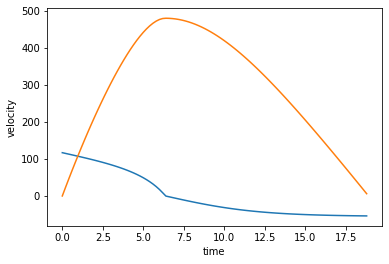

In [11]:
# Testing the simulation
# mode = 'VACCUM'
medium = 'AIR_QUADRATIC_DRAG'
times, velocities, displacements = simulate_flight(117.09523409, medium)
plot_simulation(times, velocities, displacements)

## The Data
Now that we have a physics simulation, let us run few simulations and collect the data. i,e we input few random initial velocities, times and get the corresponding velocities during the flight.

For this specific task, let us keep the initial velocities between $0$ to $100$ and time step range betwen $0$ to time of flight $T.$ 

$$u_0 \in (0, 100)$$

The collected data would look like this, $X, Y$ where
$X = (u, t), Y = (v)$   
$u, t$ represent initial velocity and time step, where as $v$ represents corresponding velocity.

In [12]:
import numpy as np

In [13]:
# Min and Max of initial velocity (in m/s)
U0_MIN = 0
U0_MAX = 100

def create_data(N_DATA_SAMPLES, D_TYPE, medium, U0_MIN=U0_MIN, U0_MAX=U0_MAX):
  if D_TYPE not in ['VELOCITY', 'DISPLACEMENT', 'VELOCITY_DISPLACEMENT']:
    return
  data = []
  for i in range(N_DATA_SAMPLES):
    u0 = U0_MIN + np.random.rand(1)*(U0_MAX - U0_MIN)
    T   = time_of_flight(u0, medium)
    t   = np.random.rand(1)*T
    v_t = velocity_t(u0, t, medium)
    s_t = displacement_t(u0, t, medium)

    # create a data point
    Y = None
    if D_TYPE=='VELOCITY':
      Y = np.array([v_t])
    elif D_TYPE=='DISPLACEMENT':
      Y = np.array([s_t])
    elif D_TYPE=='VELOCITY_DISPLACEMENT':
      Y = np.array([v_t, s_t])
    else:
      return

    # print(Y)
    datapoint = (np.array([u0, t]), Y)
    data.append(datapoint)

  print("Dataset created!!")
  print("Dataset size", len(data))
  return data

## Only Deep Learing based approach

We have collectd some data, Let us use a simple neural network to train upon that data to predict the velocity $v_t$ at a time $t$, given an initial veclocity $u_0$.

We will be experimenting with various models, train them and try the inference.

In [14]:
# Necessary modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")
print(device)

cuda:0


In [15]:
def compare_plot(times, actual, predicted, D_TYPE):
  plt.figure()
  plt.title(f" Plot for {D_TYPE}")
  plt.plot(times, actual, linewidth=2, label='Actual values')
  plt.plot(times, predicted, linewidth=2, label='Predicted')
  plt.ylabel(D_TYPE)
  plt.xlabel('time')
  plt.legend(fontsize=14)
  plt.show()

In [16]:
# Plotting the train loss curve
def loss_plot(epochs, losses):
  plt.figure()
  plt.plot(epochs, losses, 'r')
  plt.ylabel("Loss")
  plt.xlabel('Epoch')
  plt.show()

### Dataset
Let us define the appropriate dataset.

In [17]:

# Dataset
class PhysicsData(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    return self.data[index]

### Inference
Let us first create and keep the inference part ready, so that we could infer and check the infered simulation on any trained network. This will make our life easier to test with various models we might try out until a good fitting one is found.

This is to infer the output for a single input, say at time $t$, for given initial velocity $u_0$

In [18]:
# Infer the output for a single input (at time t, given initial velocity) on the trained network.
# Assuming model is already transferred to the device.
def single_inference(D_TYPE, model, u0, t):
  input   = torch.tensor([[u0, t]])
  input   = input.unsqueeze(0)
  input   = input.to(device)
  output  = model(input.float())
  output  = output.cpu().data.numpy()

  if D_TYPE=='VELOCITY':
    return output[0][0][0], 0
  elif D_TYPE=='DISPLACEMENT':
    return 0, output[0][0][0]
  elif D_TYPE=='VELOCITY_DISPLACEMENT':
    return output[0][0][0], output[0][0][1]
  else:
    return

Now, let us use the single inference to infer the whole simulation, given the initial velocity $u_0$

In [19]:
def simulation_inference(D_TYPE, model, u0, medium):
  model = model.to(device)
  T = time_of_flight(u0, medium) # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = None
    s_t = None
    v_t, s_t = single_inference(D_TYPE, model, u0, t)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

### Training
We write the appropriate training module to train any generic model with specified parameters

In [20]:
# Training
def train(model, train_dataloader, optimizer, criterion, epochs, verbose=False):
  model = model.to(device)
  model.train()

  all_epochs = []
  all_losses = []

  epoch_loss = 0.0
  for epoch in range(epochs):
    epoch_loss = 0.0
    for i, batch in enumerate(train_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      optimizer.zero_grad()
      loss = criterion(Y_predicted, Y.float(), X.float())
      epoch_loss = epoch_loss+loss.item()
      loss.backward()
      optimizer.step()

    if verbose:
      print(f"epoch : {epoch+1}, loss : {epoch_loss/len(train_dataloader):.5f}")
    else:
      if epoch%10 == 0:
        print(f"epoch : {epoch}, loss : {epoch_loss/len(train_dataloader):.5f}")

    all_epochs.append(epoch+1)
    all_losses.append(epoch_loss/len(train_dataloader))
  
  print("Done Training!")
  print(f"epoch : {epochs}, loss : {epoch_loss/len(train_dataloader):.5f}")
  return model, all_losses, all_epochs


In [21]:
# Testing
def test(model, test_dataloader, criterion):
  model = model.to(device)
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      loss = criterion(Y_predicted, Y.float(), X.float())
      total_loss = total_loss+loss.item()

  avarage_loss = total_loss/len(test_dataloader)
  print(f"Average loss : {avarage_loss:.5f}")
  return avarage_loss

### Models
Define various models.

In [22]:
# A Simple model for predicting only Velocity
class VelocityNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=5)
    self.nn2 = nn.Linear(in_features=5, out_features=5)
    self.nn3 = nn.Linear(in_features=5, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

In [23]:
# Simple model for predicting Displacement
# Similar to the Velocity Model, but has more neurons.
class DisplacementNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=16)
    self.nn3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

In [24]:
# Simple model for predicting both Velocity and Displacement
class NewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.tanh(x)
    x = self.nn2(x)
    x = self.tanh(x)
    x = self.nn3(x)
    return x

### Experiments
We run experiments on various models, keep track of hyperparameters, run inference and try to find the best model for our goal.

Let us define custom Loss class to handle various losses we might design later

In [25]:
# Define custom loss
class CustomMSELoss(nn.Module):
  def __init__(self):
    super(CustomMSELoss, self).__init__()
    self.mseLoss = nn.MSELoss()

  def forward(self, Y_predicted, Y_actual, X):
    loss = self.mseLoss(Y_predicted, Y_actual)
    return loss

#### Predicting only Velocity
Let us use the simplest model, VelocityNewtonNet to predict velocity.
We will create a dataset of 10000 entries for this.

In [118]:
N_DATA_SAMPLES = 10000
simulation_data_velocity = create_data(N_DATA_SAMPLES, 'VELOCITY', 'AIR_QUADRATIC_DRAG', 20, 120)
# simulation_data_velocity = create_data(N_DATA_SAMPLES, 'VELOCITY', 'VACCUM', 20, 120)
train_dataset_velocity_10000 = PhysicsData(simulation_data_velocity[:int(N_DATA_SAMPLES*0.8)])
test_dataset_velocity_10000 = PhysicsData(simulation_data_velocity[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


Train the network on the velocity dataset.

In [48]:
BATCH_SIZE          = 16
model_v             = VelocityNewtonNet()
train_dataloader_v  = DataLoader(train_dataset_velocity_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v         = optim.SGD(model_v.parameters(), lr= 0.000001, momentum=0.9)
optimizer_v         = optim.Adam(model_v.parameters(), lr = 0.0005)
criterion           = CustomMSELoss()
epochs              = 100

epoch : 0, loss : 1503.75759
epoch : 10, loss : 26.31486
epoch : 20, loss : 18.66192
epoch : 30, loss : 14.22097
epoch : 40, loss : 11.46101
epoch : 50, loss : 9.38373
epoch : 60, loss : 7.63458
epoch : 70, loss : 6.36066
epoch : 80, loss : 5.39865
epoch : 90, loss : 4.44989
Done Training!
epoch : 100, loss : 3.85312


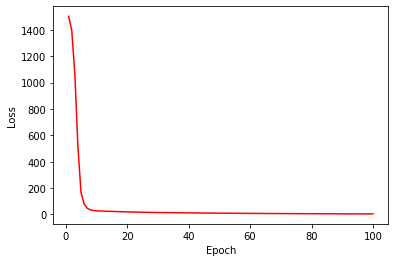

In [49]:
model_v, t_loss, t_epochs = train(model_v, train_dataloader_v, optimizer_v, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

Calculate the test loss and run few inferences to visualise the prediction.

In [50]:
# Test loss
test_dataloader_v = DataLoader(test_dataset_velocity_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v, test_dataloader_v, criterion)

Average loss : 3.59959


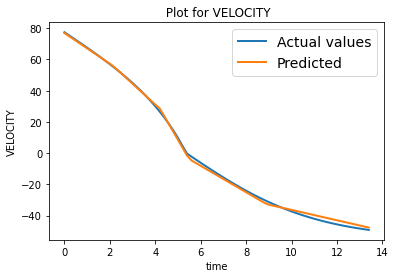

In [51]:
# Run simulation and compare
U_INITIAL = 77.4356

times_p, velocities_p, displacements_p = simulation_inference('VELOCITY', model_v, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')

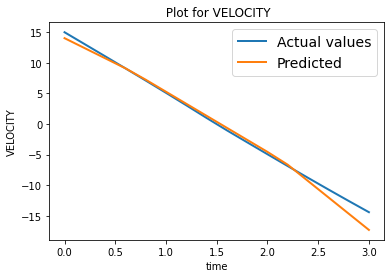

In [53]:

# Run simulation and compare, a case where it doesn't match exactly
U_INITIAL = 15
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY', model_v, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')

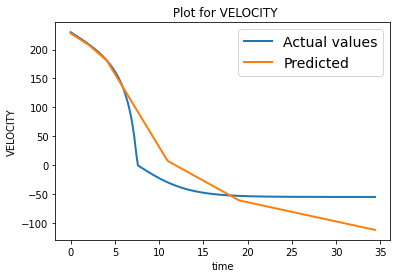

In [54]:
# Run simulation and compare, a case where u0 is out of dataset domain
U_INITIAL = 230
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY', model_v, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')

#### Predicting only Displacement

In [119]:
# Let us create a similar dataset for displacement task
N_DATA_SAMPLES                    = 10000
simulation_data_displacement      = create_data(N_DATA_SAMPLES, 'DISPLACEMENT', 'AIR_QUADRATIC_DRAG', 20, 120)
train_dataset_displacement_10000  = PhysicsData(simulation_data_displacement [:int(N_DATA_SAMPLES*0.8)])
test_dataset_displacement_10000   = PhysicsData(simulation_data_displacement [int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


In [56]:
BATCH_SIZE          = 16
model_s             = DisplacementNewtonNet()
train_dataloader_s  = DataLoader(train_dataset_displacement_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_s         = optim.SGD(model_s.parameters(), lr= 0.000001, momentum=0.9)
optimizer_s         = optim.Adam(model_s.parameters(), lr = 0.005)
criterion           = CustomMSELoss()
epochs              = 100

epoch : 0, loss : 8053.06083
epoch : 10, loss : 127.89303
epoch : 20, loss : 38.93174
epoch : 30, loss : 45.98496
epoch : 40, loss : 36.11227
epoch : 50, loss : 25.85079
epoch : 60, loss : 37.63763
epoch : 70, loss : 23.48817
epoch : 80, loss : 25.91823
epoch : 90, loss : 21.98562
Done Training!
epoch : 100, loss : 18.71204


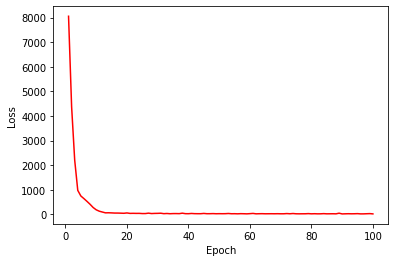

In [57]:
model_s, t_loss, t_epochs = train(model_s, train_dataloader_s, optimizer_s, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

In [58]:
# Test loss
test_dataloader_s = DataLoader(test_dataset_displacement_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_s, test_dataloader_s, criterion)

Average loss : 12.75279


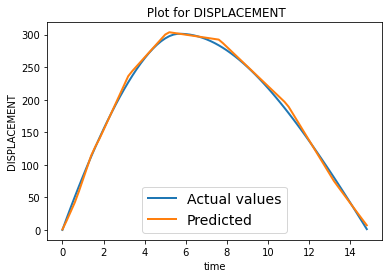

In [59]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

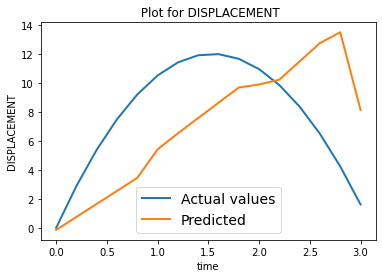

In [60]:
# Run simulation and compare, a case where u0 is small
U_INITIAL = 15.434
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

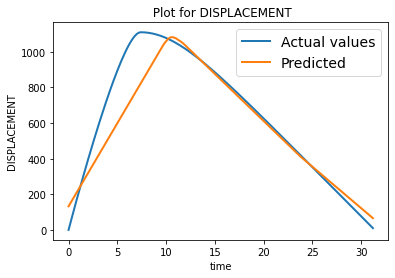

In [61]:
# Run simulation and compare, a case where u0 is not in dataset domain
U_INITIAL = 207.434
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

#### Predicting both Velocity and Displacement

In [120]:
# Let us create a similar dataset for velocity, displacement task
N_DATA_SAMPLES                    = 10000
simulation_data_v_s               = create_data(N_DATA_SAMPLES, 'VELOCITY_DISPLACEMENT', 'AIR_QUADRATIC_DRAG')
train_dataset_v_s_10000           = PhysicsData(simulation_data_v_s[:int(N_DATA_SAMPLES*0.8)])
test_dataset_v_s_10000            = PhysicsData(simulation_data_v_s[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


In [63]:
BATCH_SIZE            = 16
model_v_s             = NewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s         = optim.SGD(model_v_s.parameters(), lr=0.000001, momentum=0.9)
optimizer_v_s         = optim.Adam(model_v_s.parameters(), lr = 0.005)
criterion             = CustomMSELoss()
epochs                = 100

epoch : 0, loss : 7669.50986
epoch : 10, loss : 2308.47159
epoch : 20, loss : 609.57888
epoch : 30, loss : 142.09739
epoch : 40, loss : 58.79301
epoch : 50, loss : 36.60021
epoch : 60, loss : 37.26972
epoch : 70, loss : 30.18153
epoch : 80, loss : 45.67903
epoch : 90, loss : 24.67704
Done Training!
epoch : 100, loss : 26.65118


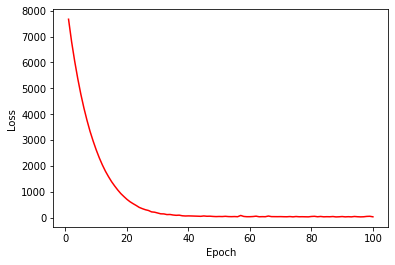

In [64]:
model_v_s, t_loss, t_epochs = train(model_v_s, train_dataloader_v_s, optimizer_v_s, criterion, epochs)
loss_plot(t_epochs, t_loss)

In [65]:
# Test loss
test_dataloader_v_s = DataLoader(test_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s, test_dataloader_v_s, criterion)

Average loss : 46.03700


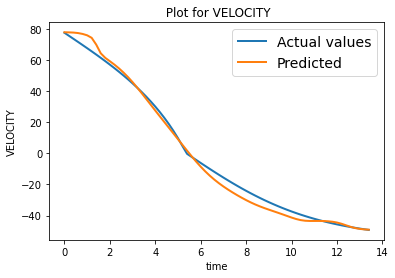

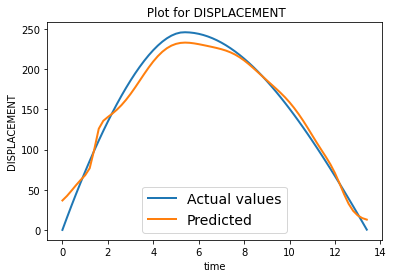

In [66]:
# Run simulation and compare
U_INITIAL = 77.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

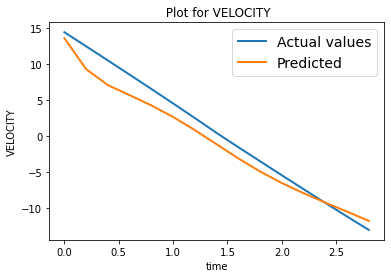

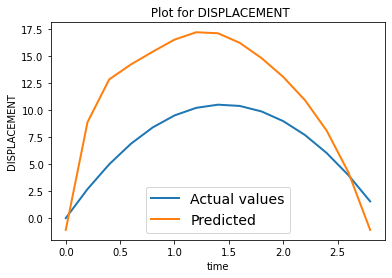

In [67]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

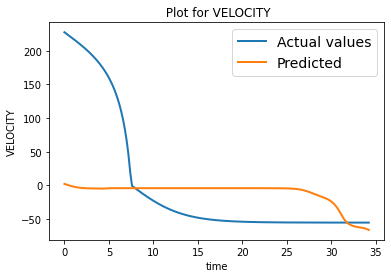

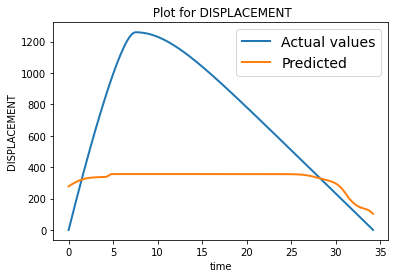

In [68]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 227.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Using Physics Knowledge for training
As we know some properties of the predicted values from physics, like the velocities over time lie on a line, displacements over time lie on a parabola and also $v_t$, $s_t$ have the following relation   

$v_t^2-u_0^2 = 2*g*s_t$

Let us try to leverage this knowledge and see if it improves our model.

In [69]:
# Simple model for predicting both Velocity and Displacement
class PhysicsNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

#### Designing a Loss function
We are trying to predict two values namely $v_t$ and $s_t$. From our previous experiments, it is evident that prediction of velocity is fairly accurate even for a minimal network, however prediction of displacement is in accurate and kind of overfit. 

##### 1. Physics based loss
Leveraging the relationship between predicted values $v_t$ and $s_t$, let us try experimenting with the following loss purly based on physics.

$L_{physics} = |v_{predicted}^2-u_{initial}^2-2*g*s_{predicted}| $

In [70]:
# Define new loss
class PhysicsBasedLoss(nn.Module):
  def __init__(self):
    super(PhysicsBasedLoss, self).__init__()

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), 2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s) 
    absolute_difference = torch.absolute(difference)
    loss = torch.sum(absolute_difference)
    return loss

In [73]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE            = 16
model_v_s_phy         = PhysicsNewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_phy     = optim.SGD(model_v_s_phy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_phy     = optim.Adam(model_v_s_phy.parameters(), lr = 0.0005)
criterion             = PhysicsBasedLoss()
epochs                = 100

epoch : 0, loss : 15284.45321
epoch : 10, loss : 56.99702
epoch : 20, loss : 78.31946
epoch : 30, loss : 82.70061
epoch : 40, loss : 68.65334
epoch : 50, loss : 67.46962
epoch : 60, loss : 77.81361
epoch : 70, loss : 69.43151
epoch : 80, loss : 62.02823
epoch : 90, loss : 56.12098
Done Training!
epoch : 100, loss : 66.00265


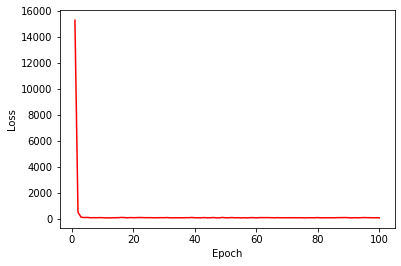

In [74]:
model_v_s_phy, t_loss, t_epochs = train(model_v_s_phy, train_dataloader_v_s, optimizer_v_s_phy, criterion, epochs)
loss_plot(t_epochs, t_loss)

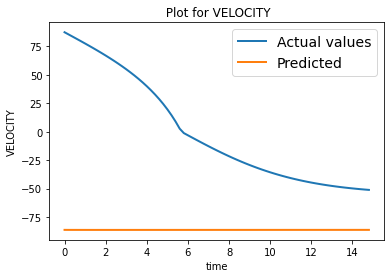

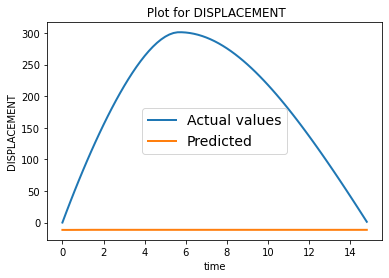

In [82]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

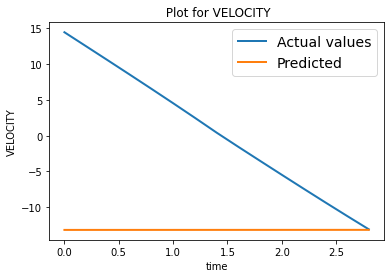

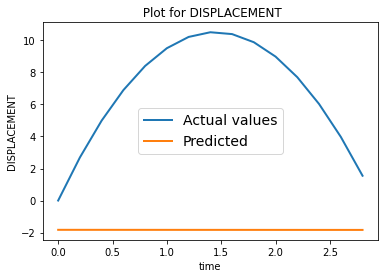

In [76]:
# Run simulation and compare, smaller velocity
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

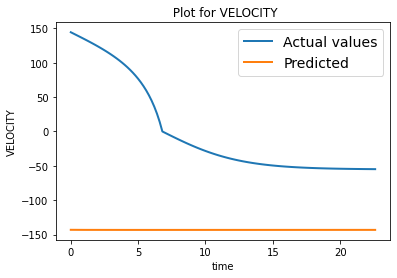

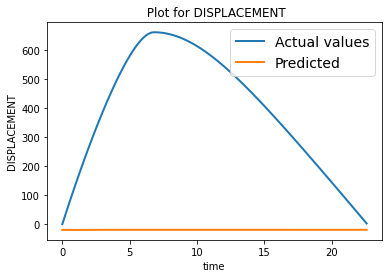

In [77]:
# Run simulation and compare, out of domain velocity
U_INITIAL = 144.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

First of all, the model hasn't converged fully. However, the predictions make sense as we are not using the time input. The model just learns to predict $v_t, s_t$, such that the physics equation holds, but they need not be consistent with the one's we are expecting in a flight. In this case, looks like the model is predictin $s_t=0$, and therefore $v_t\sim u_0$.

##### 2. Velocity + Physics based loss
Let us try the folowing loss where we try to make the velocity closer to actual velocity but provide no ground truth information on displacement, rather we make use of the relation between $v_t$, $s_t$ to guide the learning.

$L_{velocity+phy} = (v_{predicted}-v_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$

$\gamma$ is used to control weightage given to the physics term.

This will go to $0$ only when $v_{predicted} = v_{actual}$ and $v_{predicted}^2-u_{initial}^2 = 2*g*s_{predicted}$, both of which yield correct prediction for $v_t$ and $s_t$

In [78]:
class VelocityPlusPhysicsBasedLoss(nn.Module):
  def __init__(self, gamma):
    super(VelocityPlusPhysicsBasedLoss, self).__init__()
    self.gamma = gamma

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), -2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    squared_difference = torch.square(difference)

    v_actual = Y_actual[:, :, 0]
    difference_v = torch.subtract(v_predicted, v_actual)
    squared_difference_v = torch.square(difference_v)
    sqr_diff_sum = torch.add(squared_difference_v, self.gamma*squared_difference)

    loss = torch.sum(sqr_diff_sum)
    return loss

In [79]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE                  = 16
model_v_s_velocityPhy       = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_velocityPhy   = optim.SGD(model_v_s_velocityPhy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_velocityPhy   = optim.Adam(model_v_s_velocityPhy.parameters(), lr = 0.0005)
criterion                   = VelocityPlusPhysicsBasedLoss(gamma=0.00001)
epochs                      = 100

epoch : 0, loss : 17465.91528
epoch : 10, loss : 8435.02852
epoch : 20, loss : 463.27058
epoch : 30, loss : 417.98707
epoch : 40, loss : 394.90473
epoch : 50, loss : 372.11775
epoch : 60, loss : 347.94967
epoch : 70, loss : 321.92505
epoch : 80, loss : 299.87670
epoch : 90, loss : 277.13282
Done Training!
epoch : 100, loss : 257.55843


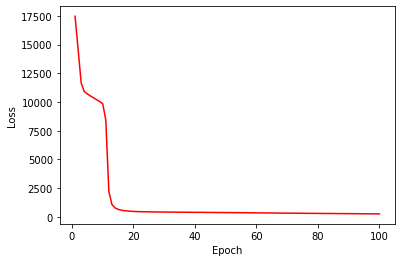

In [80]:
model_v_s_velocityPhy, t_loss, t_epochs = train(model_v_s_velocityPhy, train_dataloader_v_s, optimizer_v_s_velocityPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

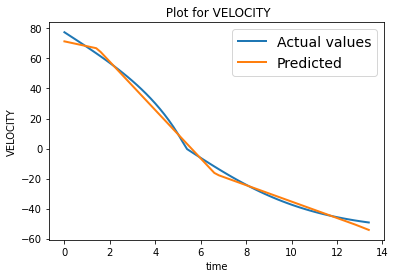

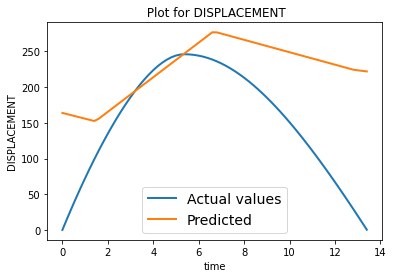

In [83]:
# Run simulation and compare
U_INITIAL = 77.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

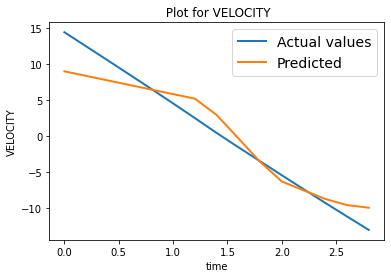

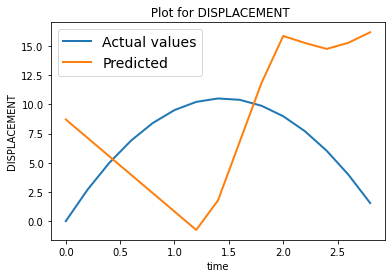

In [84]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

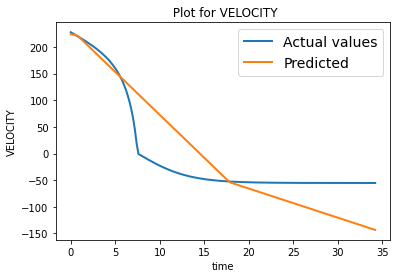

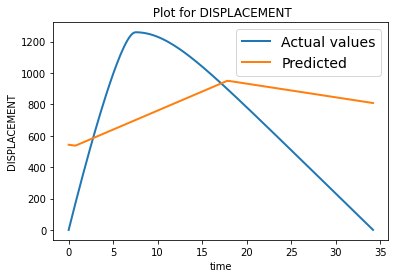

In [85]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 227.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

The above experiment clearly shows that even without direct supervision on $s_t$, we have obtained equivalent results compared to direct supervision.

##### 2. Supervised + Physics based loss

Let us try out including both supervision and physics to guide our learning. We will use the following loss function.

$L_{supervised+phy} = (v_{predicted}-v_{actual})^2+(s_{predicted}-s_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$

$\gamma$ is used to control weightage given to the physics term.

In [86]:
class SupervisedPlusPhysicsBasedLoss(nn.Module):
  def __init__(self, gamma):
    super(SupervisedPlusPhysicsBasedLoss, self).__init__()
    self.gamma = gamma

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), -2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    squared_difference = torch.square(difference)

    # supervised v term
    v_actual = Y_actual[:, :, 0]
    difference_v = torch.subtract(v_predicted, v_actual)
    squared_difference_v = torch.square(difference_v)

    # supervised s term
    s_actual = Y_actual[:, :, 1]
    difference_s = torch.subtract(s_predicted, s_actual)
    squared_difference_s = torch.square(difference_s)

    sqr_diff_sum = torch.add(squared_difference_v, squared_difference_s)
    sqr_diff_sum = torch.add(sqr_diff_sum, self.gamma*squared_difference)

    loss = torch.sum(sqr_diff_sum)
    loss = loss/X.shape[0]
    return loss

In [153]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE                  = 16
model_v_s_supervisedPhy     = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_velocityPhy   = optim.SGD(model_v_s_velocityPhy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_supervisedPhy = optim.Adam(model_v_s_supervisedPhy.parameters(), lr = 0.005)
criterion                   = SupervisedPlusPhysicsBasedLoss(gamma=0.0001)
epochs                      = 100

epoch : 0, loss : 6140.34983
epoch : 10, loss : 437.95626
epoch : 20, loss : 329.23082
epoch : 30, loss : 298.88892
epoch : 40, loss : 287.10151
epoch : 50, loss : 277.32693
epoch : 60, loss : 275.57068
epoch : 70, loss : 270.12933
epoch : 80, loss : 267.66328
epoch : 90, loss : 270.12307
Done Training!
epoch : 100, loss : 265.34849


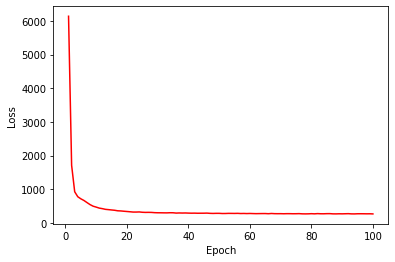

In [154]:
model_v_s_supervisedPhy, t_loss, t_epochs = train(model_v_s_supervisedPhy, train_dataloader_v_s, optimizer_v_s_supervisedPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

In [155]:
# Test loss
test_dataloader_supervisedPhy = DataLoader(test_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s_supervisedPhy, test_dataloader_supervisedPhy, criterion)

Average loss : 265.88762


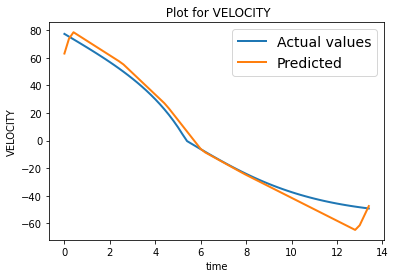

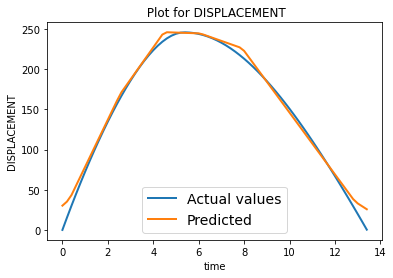

In [157]:
# Run simulation and compare
U_INITIAL = 77.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

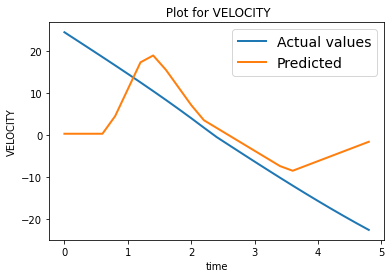

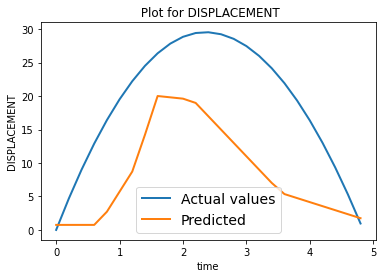

In [160]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 24.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

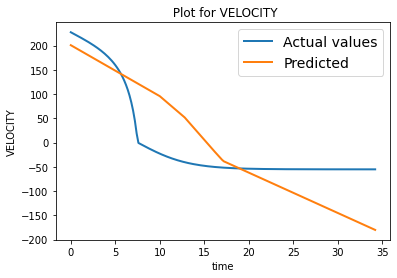

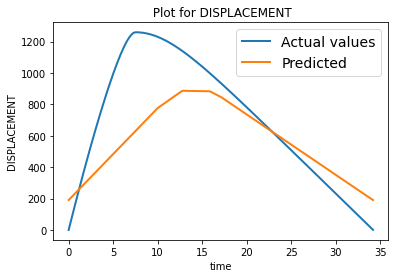

In [159]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 227.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

Looks like physics guide is helping us. The plots look a bit smoother than the ones without using physics term. 

## Data Starvation experiments

Until now we have been providing the 10000 samples for our experiment. Let us now predict the displacement for both approaches using less data.

## Data starvation Only DL based

Let use only 5 percent of data. i.e 100 samples to learn the equations using only DL

In [179]:
N_DATA_SAMPLES                    = 500
simulation_data_v_s               = create_data(N_DATA_SAMPLES, 'VELOCITY_DISPLACEMENT', 'AIR_QUADRATIC_DRAG')
train_dataset_v_s_500           = PhysicsData(simulation_data_v_s[:int(N_DATA_SAMPLES*0.8)])
test_dataset_v_s_500            = PhysicsData(simulation_data_v_s[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 500


In [180]:
BATCH_SIZE            = 16
model_v_s             = NewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_500, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s         = optim.SGD(model_v_s.parameters(), lr=0.000001, momentum=0.9)
optimizer_v_s         = optim.Adam(model_v_s.parameters(), lr = 0.005)
criterion             = CustomMSELoss()
epochs                = 2000

epoch : 0, loss : 9457.94157
epoch : 10, loss : 8866.78971
epoch : 20, loss : 8354.20752
epoch : 30, loss : 7883.08001
epoch : 40, loss : 7448.64608
epoch : 50, loss : 7031.43463
epoch : 60, loss : 6635.36924
epoch : 70, loss : 6256.04842
epoch : 80, loss : 5895.61545
epoch : 90, loss : 5560.44863
epoch : 100, loss : 5243.52980
epoch : 110, loss : 4943.53440
epoch : 120, loss : 4657.79387
epoch : 130, loss : 4388.64404
epoch : 140, loss : 4134.15363
epoch : 150, loss : 3901.80461
epoch : 160, loss : 3663.04261
epoch : 170, loss : 3441.76853
epoch : 180, loss : 3233.13540
epoch : 190, loss : 3048.87782
epoch : 200, loss : 2860.14398
epoch : 210, loss : 2681.22392
epoch : 220, loss : 2520.45631
epoch : 230, loss : 2366.04741
epoch : 240, loss : 2220.21356
epoch : 250, loss : 2088.82145
epoch : 260, loss : 1953.79935
epoch : 270, loss : 1837.47285
epoch : 280, loss : 1707.78258
epoch : 290, loss : 1604.80086
epoch : 300, loss : 1489.77595
epoch : 310, loss : 1389.33016
epoch : 320, loss :

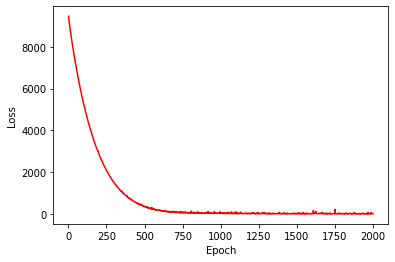

In [181]:
model_v_s, t_loss, t_epochs = train(model_v_s, train_dataloader_v_s, optimizer_v_s, criterion, epochs)
loss_plot(t_epochs, t_loss)

In [183]:
# Test loss
test_dataloader_v_s = DataLoader(test_dataset_v_s_500, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s, test_dataloader_v_s, criterion)

Average loss : 12.14425


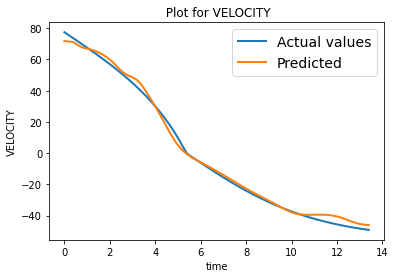

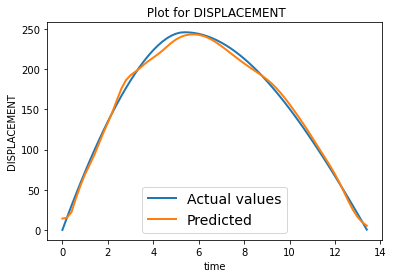

In [184]:
# Run simulation and compare
U_INITIAL = 77.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

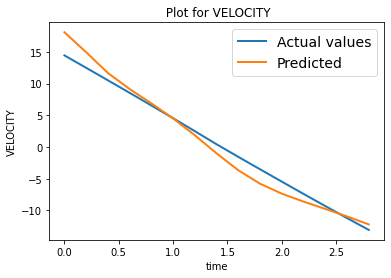

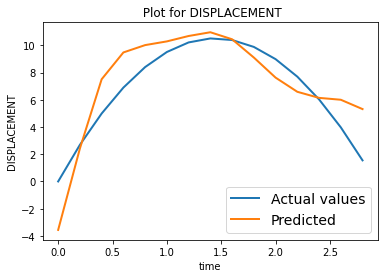

In [185]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

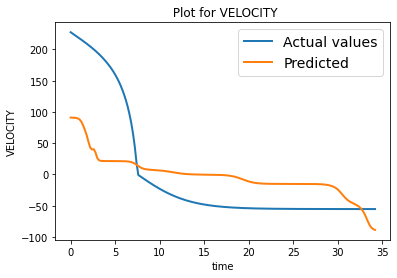

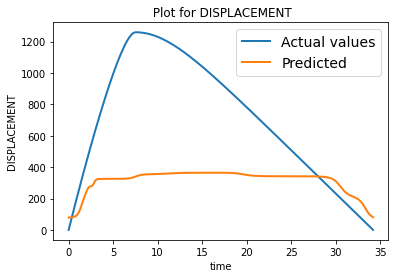

In [186]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 227.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Data starvation DL + Physics Based

using only 500 samples for DL + PhysicsBased

In [193]:
N_DATA_SAMPLES                    = 500
simulation_data_v_s               = create_data(N_DATA_SAMPLES, 'VELOCITY_DISPLACEMENT', 'AIR_QUADRATIC_DRAG')
train_dataset_v_s_500           = PhysicsData(simulation_data_v_s[:int(N_DATA_SAMPLES*0.8)])
test_dataset_v_s_500            = PhysicsData(simulation_data_v_s[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 500


In [194]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE                  = 16
model_v_s_supervisedPhy     = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(train_dataset_v_s_500, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_velocityPhy   = optim.SGD(model_v_s_velocityPhy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_supervisedPhy = optim.Adam(model_v_s_supervisedPhy.parameters(), lr = 0.005)
criterion                   = SupervisedPlusPhysicsBasedLoss(gamma=0.0001)
epochs                      = 2000

epoch : 0, loss : 19631.61023
epoch : 10, loss : 19400.94123
epoch : 20, loss : 4924.02732
epoch : 30, loss : 2981.97655
epoch : 40, loss : 1764.56810
epoch : 50, loss : 1141.07815
epoch : 60, loss : 866.76751
epoch : 70, loss : 789.62588
epoch : 80, loss : 743.15417
epoch : 90, loss : 664.10428
epoch : 100, loss : 655.35829
epoch : 110, loss : 607.74345
epoch : 120, loss : 613.35758
epoch : 130, loss : 591.30707
epoch : 140, loss : 584.03264
epoch : 150, loss : 586.83358
epoch : 160, loss : 585.32085
epoch : 170, loss : 557.24335
epoch : 180, loss : 550.26562
epoch : 190, loss : 547.37437
epoch : 200, loss : 525.84854
epoch : 210, loss : 519.59421
epoch : 220, loss : 526.36990
epoch : 230, loss : 515.76147
epoch : 240, loss : 533.46491
epoch : 250, loss : 514.61335
epoch : 260, loss : 512.21681
epoch : 270, loss : 499.52120
epoch : 280, loss : 515.04049
epoch : 290, loss : 487.10970
epoch : 300, loss : 491.89513
epoch : 310, loss : 475.28950
epoch : 320, loss : 469.06500
epoch : 330, 

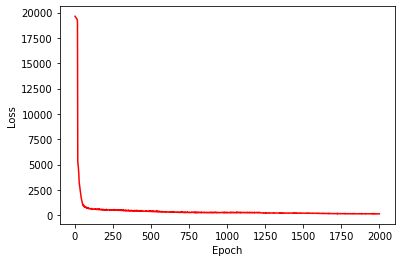

In [195]:
model_v_s_supervisedPhy, t_loss, t_epochs = train(model_v_s_supervisedPhy, train_dataloader_v_s, optimizer_v_s_supervisedPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

In [196]:
# Test loss
test_dataloader_v_s = DataLoader(test_dataset_v_s_500, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s_supervisedPhy, test_dataloader_v_s, criterion)

Average loss : 215.73396


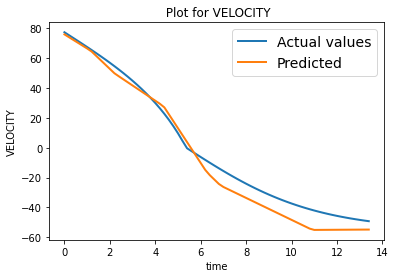

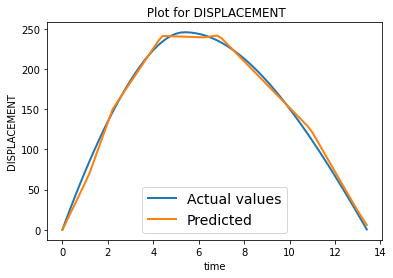

In [200]:
# Run simulation and compare
U_INITIAL = 77.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

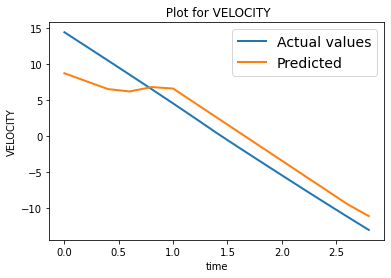

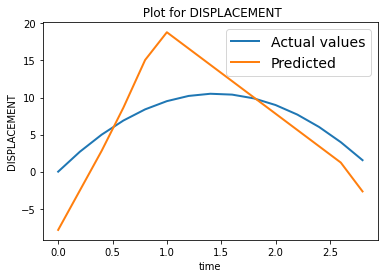

In [201]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

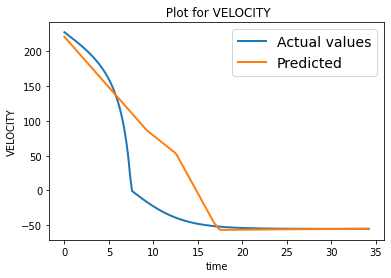

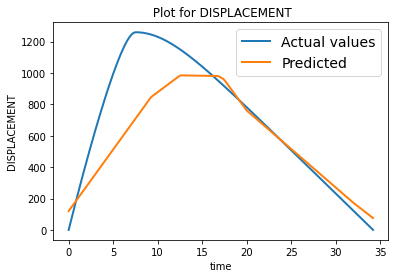

In [202]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 227.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL, 'AIR_QUADRATIC_DRAG')
times, velocities, displacements        = simulate_flight(U_INITIAL, 'AIR_QUADRATIC_DRAG')
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Summary

### Data Rich and Physics Uncertain
<style>
    .foo thead tr th:first-child,
    .foo tbody tr td:first-child {
    width: 5%;
    min-width: 1%;
    max-width: 5%;
    word-break: break-all;
    }
    .foo {
        font-size: 8pt;
    }
</style>
<div class="foo">

| Experiment 					| Parameters  											| Results  								| Comments 							|
| :---       					|    :----:   											|     :---: 							|     ---: 							|
| **DL + Data**																																						|\
| Predicting both $v_t, s_t$	| Dataset size : 10000<br> Network : 2->16->16->2 <br>	activation: tanh	|	Reasonable		| Better prediction for $u_0 \in dataset$, poor prediction outside |
| **DL + Physics**																																			|
| Predicting both $v_t, s_t$<br> using Loss $L_{physics} = \|v_{predicted}^2-u_{initial}^2-2*g*s_{predicted}\|$ | Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	~0% accuracy		| Expected result as no supervision of any kind is provided |
| Predicting both $v_t, s_t$<br> using Loss $L_{velocity+phy} = (v_{predicted}-v_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$ | Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	Reasonable	| Prediction of $v_t$ is good. Was able to learn $s_t$ reasonably well without direct supervision |
| Predicting both $v_t, s_t$<br> using Loss $L_{supervised+phy} = (v_{predicted}-v_{actual})^2+(s_{predicted}-s_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$ | Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	Reasonable	| Not a better result w.r.t direct supervision, but bettr than DL when $u0$ is out of dataset |

</div>

**Observations :** 
- Both DL, Hybrid(DL+Physics) methods performance are similar, Hybrid(DL+Physics) is better when $u0$ is out of dataset, DL is better for $u0$ in dataset.
- Physics equations are not certain in this case and the above methods are better to use than Physics.

### Data Starvation and Physics Uncertain
- Similar observations as in data rich